# Can you estimate the age of an abalone?

## 📖 Background
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

## 💾 The data
You have access to the following historical data ([source](https://archive.ics.uci.edu/ml/datasets/abalone)):

#### Abalone characteristics:
- "sex" - M, F, and I (infant).
- "length" - longest shell measurement.
- "diameter" - perpendicular to the length.
- "height" - measured with meat in the shell.
- "whole_wt" - whole abalone weight.
- "shucked_wt" - the weight of abalone meat.
- "viscera_wt" - gut-weight.
- "shell_wt" - the weight of the dried shell.
- "rings" - number of rings in a shell cross-section.
- "age" - the age of the abalone: the number of rings + 1.5.

***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

In [2]:
import pandas as pd
abalone = pd.read_csv('./data/abalone.csv')
abalone

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5


## 💪 Competition challenge
Create a report that covers the following:

1. How does weight change with age for each of the three sex categories?
2. Can you estimate an abalone's age using its physical characteristics? 
3. Investigate which variables are better predictors of age for abalones.

## 🧑‍⚖️ Judging criteria

This is a community-based competition. The top 5 most upvoted entries will win.

The winners will receive DataCamp merchandise.

# Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Exploratory Data Analysis
### Age Distribution

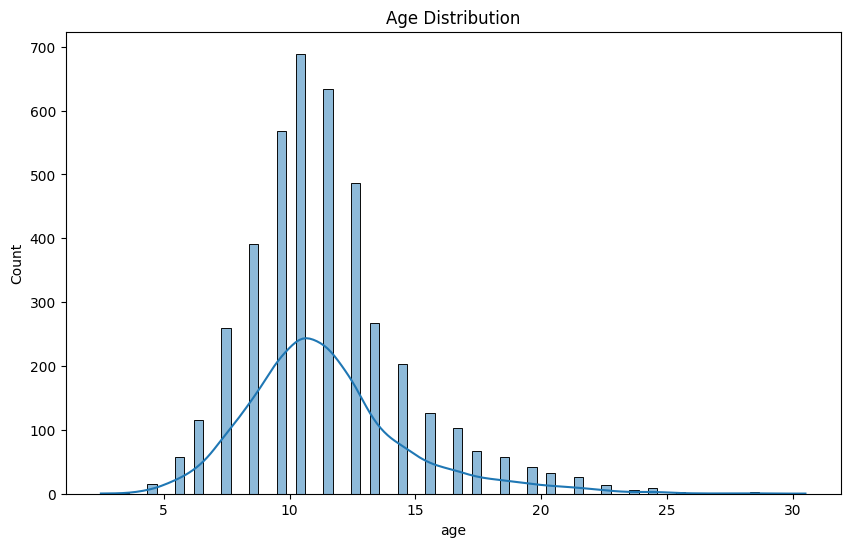

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=abalone, x='age', kde=True)
plt.title("Age Distribution")
plt.show()

### Pairwise Relationships between numerical variables

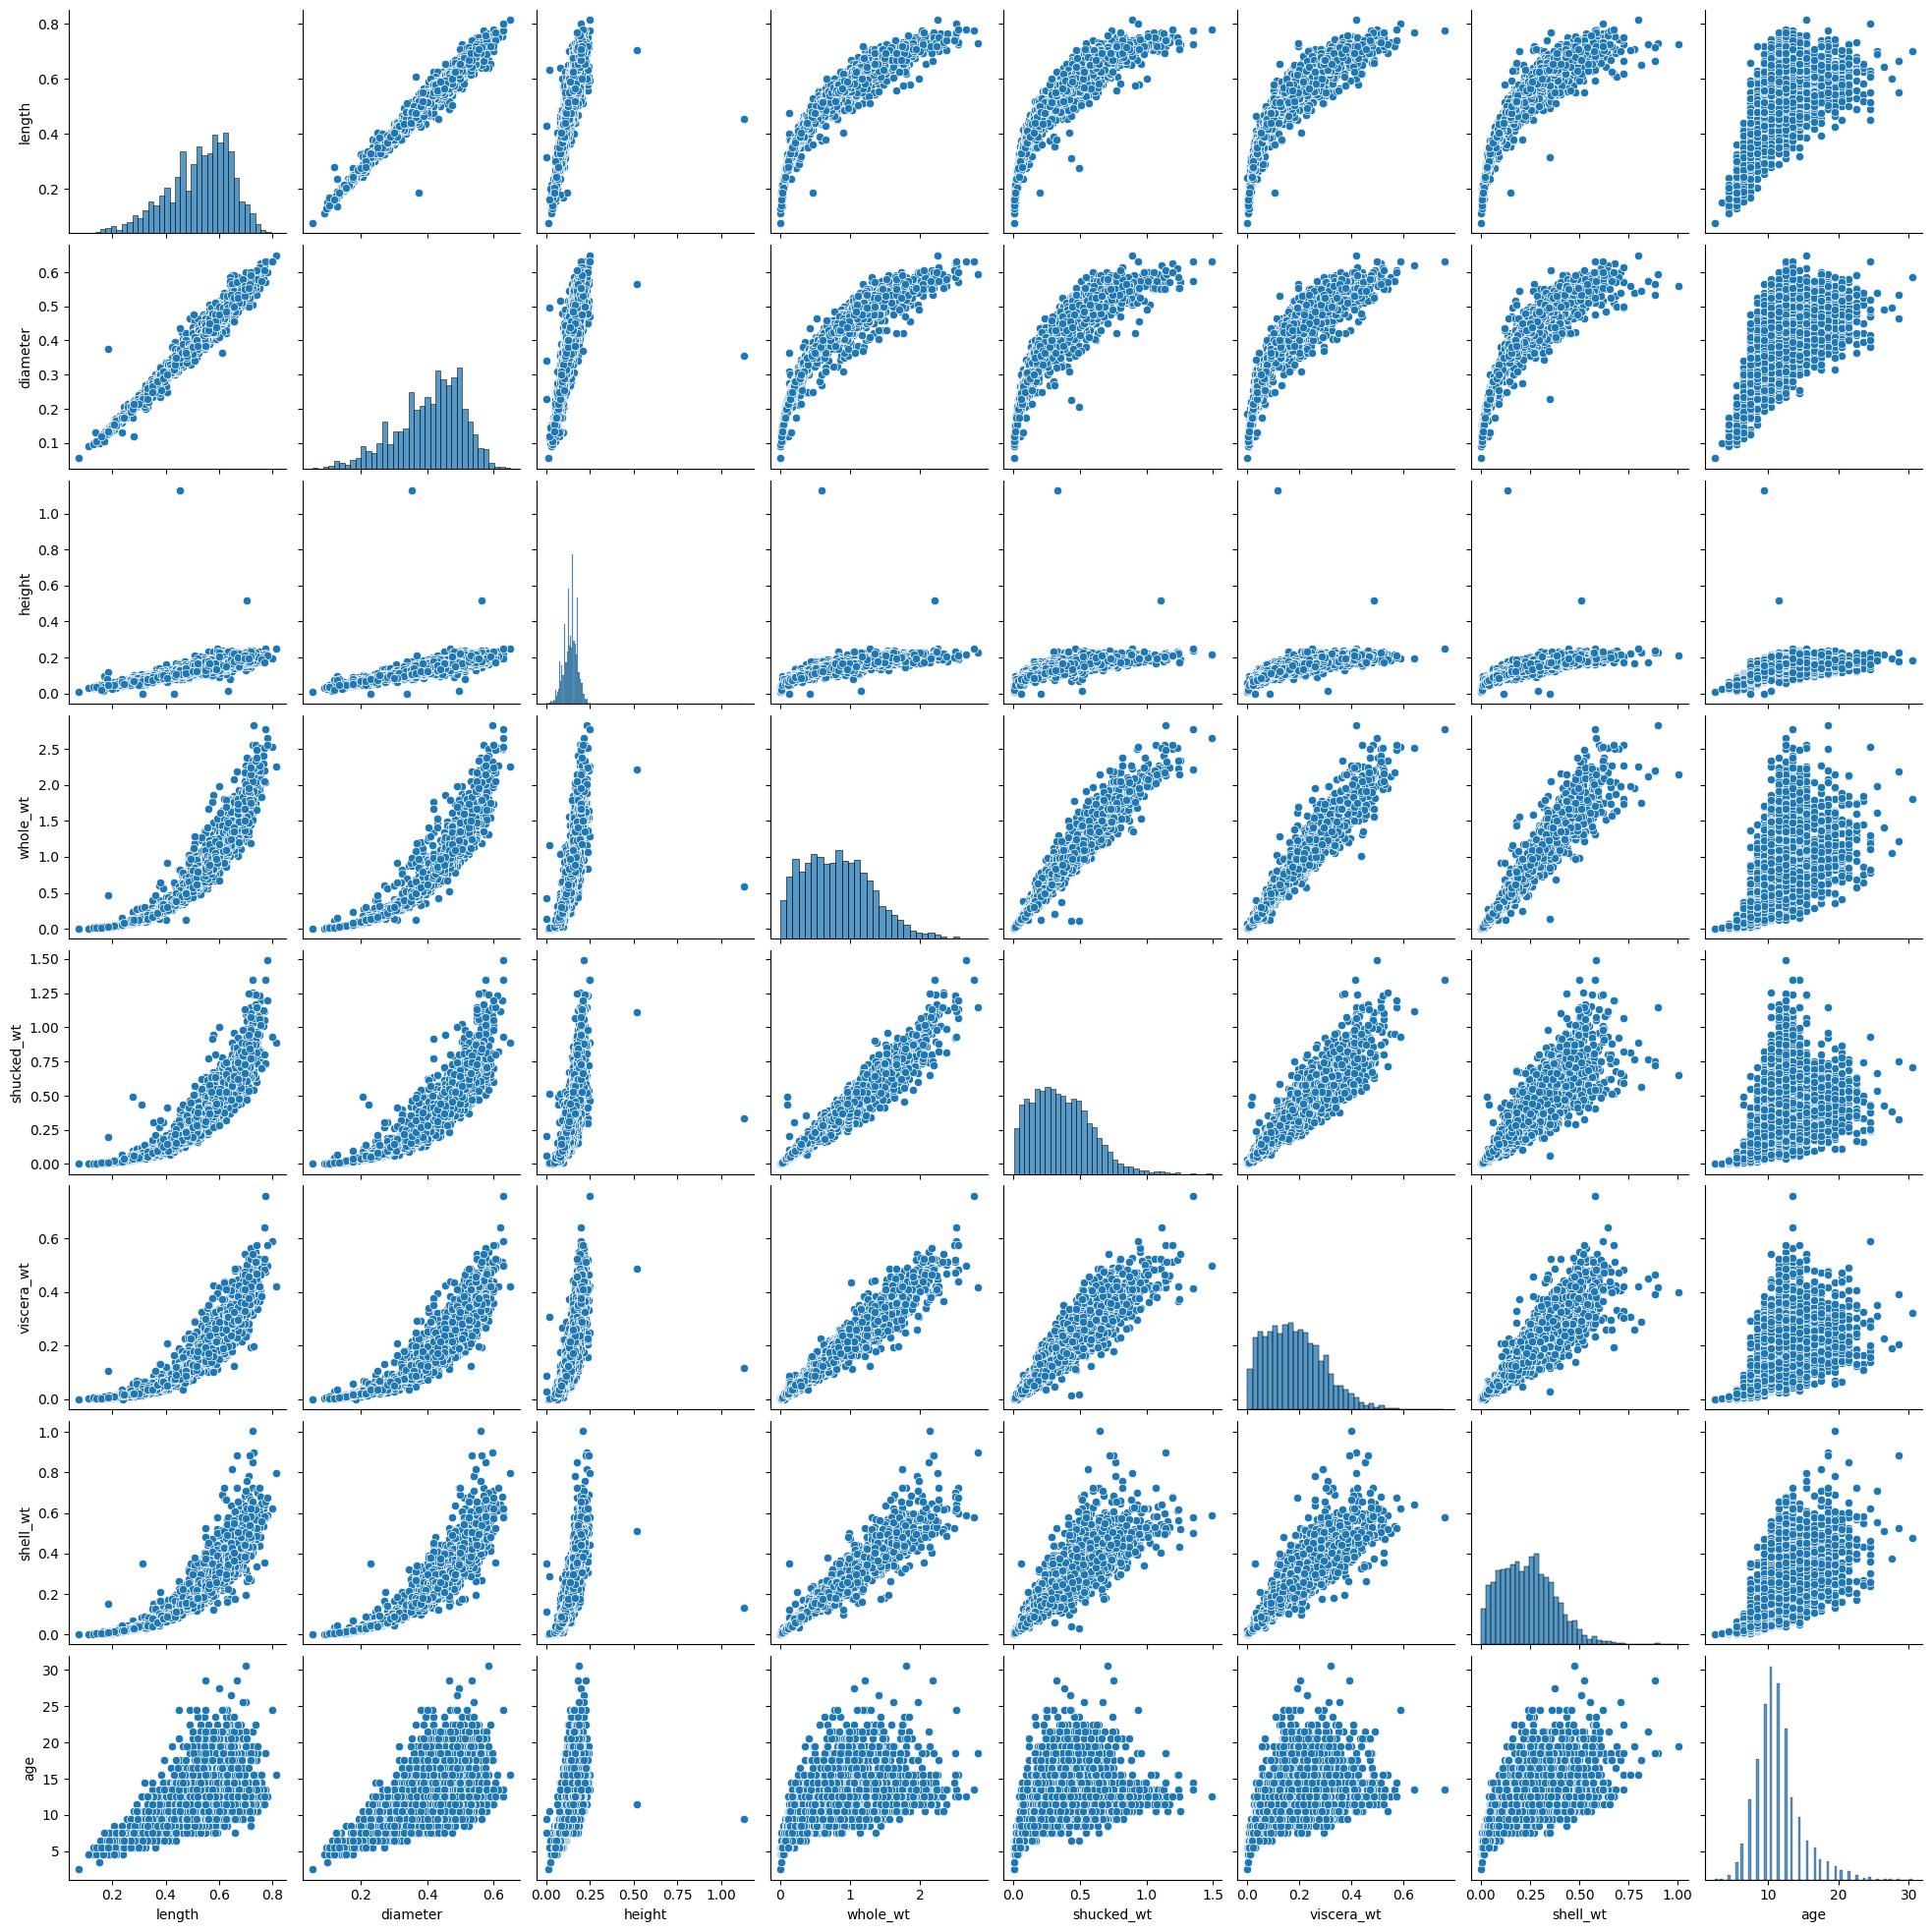

In [14]:
# select numerical columns
numerical_columns = ['length', 'diameter', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt', 'shell_wt', 'age']

# Create a pair plot
sns.pairplot(abalone[numerical_columns])
plt.show()

### Correlation matrix heatmap for numerical variables

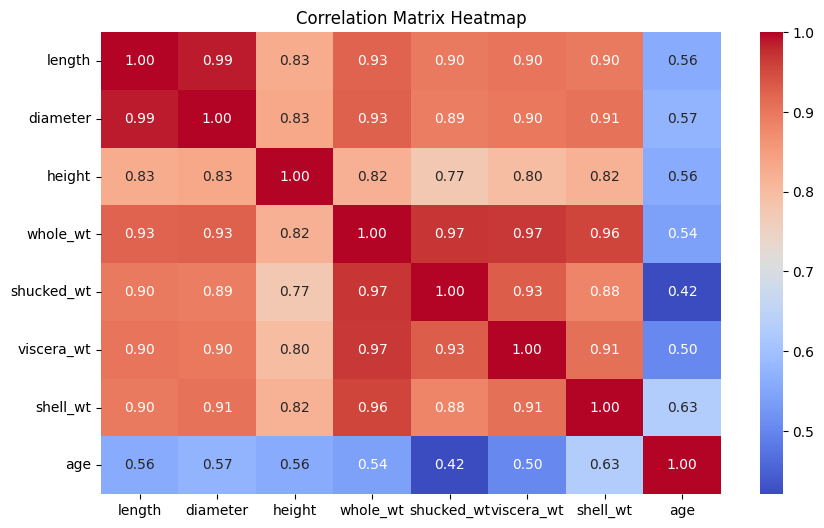

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(abalone[numerical_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

#### Observations
length and diameter have a very high positive correlation (0.986812), which means that as the length of an abalone increases, its diameter is also likely to increase. This is expected because the two dimensions are related to the overall size of the abalone.

whole_wt, shucked_wt, viscera_wt, and shell_wt are all positively correlated with each other, indicating that as one weight measurement increases, the others are likely to increase as well. This is expected because these weight measurements are related to different parts of the same abalone.

height has a strong positive correlation with length (0.827554) and diameter (0.833684). This indicates that taller abalones are generally larger in both length and diameter.

The age variable has moderate positive correlations with length (0.556720), diameter (0.574660), height (0.557467), whole_wt (0.540390), viscera_wt (0.503819), and shell_wt (0.627574). This suggests that older abalones are generally larger and heavier. However, the correlation between age and shucked_wt is relatively lower (0.420884), which might indicate that the relationship between the age of the abalone and the weight of its meat is not as strong as with other variables.

Overall, shell_wt has the highest correlation with age (0.627574), suggesting that the weight of the dried shell is the best predictor of age among the variables considered. Other variables like length, diameter, and height also show moderate correlations with age, which can provide additional information for predicting the age of abalones.

# How does weight change with age for each of the three sex categories?

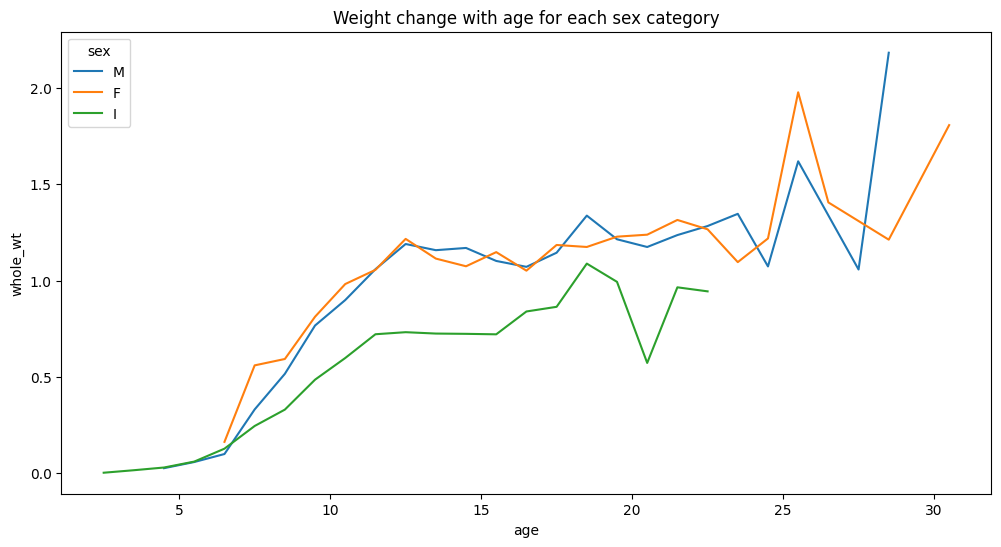

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=abalone, x='age', y='whole_wt', hue='sex', ci=None)
plt.title("Weight change with age for each sex category")
plt.show()

- Females, Males and infants all showed a general trend of increasing weight with age. For all 3 groups once they reached a certain age (25 for Male/Female) and 21 for infants the trend becomes less clear as there was both sharp decreases followed by drastic increases to weight.
- Infants have a lower weight compared to adult abalones which is to be expected.
- There is a significant amount of variation in weight for some age groups. For example the weight of females at age 25.5 is considerably higher than the weight of females at age 26.5. This could be due to several factors such as outliers, smaller sample sizes in certain age groups, or natural variability of the data.

# Estimating an abalone's age
To attempt to estimate an abalone's age using its physical characteristics we are going to use three different types of models: Linear Regression, Decision Tree and Random Forest Classifier. Before we can train our models we need to preprocess the data, split it into training and testing sets and scale the features.

In [25]:
# encode sex column
le = LabelEncoder()
abalone['sex'] = le.fit_transform(abalone['sex'])

# split data into features(X) and target(y)
X = abalone.drop(['age','rings'], axis=1)
y = abalone['age']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3211)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### Linear Regression Model

In [36]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
}

In [40]:
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)

    # Print evaluation metrics
    print(f"{model_name} Evaluation Metrics:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  Root Mean Squared Error: {rmse}")
    print(f"  R-squared: {r2}")
    print()

Linear Regression Evaluation Metrics:
  Mean Squared Error: 5.360008935646023
  Mean Absolute Error: 1.644223693070988
  Root Mean Squared Error: 2.3151693103628563
  R-squared: 0.5022158172705937

Decision Tree Evaluation Metrics:
  Mean Squared Error: 10.58133971291866
  Mean Absolute Error: 2.27511961722488
  Root Mean Squared Error: 3.2528971260890898
  R-squared: 0.017310679064644896

Random Forest Evaluation Metrics:
  Mean Squared Error: 5.247487918660288
  Mean Absolute Error: 1.6336961722488037
  Root Mean Squared Error: 2.2907396007971506
  R-squared: 0.512665647327337



- The Linear Regression model has a moderate R-squared value of 0.50, indicating that it explains about 50% of the variance in the target variable (age). The MSE, MAE, and RMSE are relatively low compared to the other models, suggesting decent performance.
- The Decision Tree model has a very low R-squared value of 0.017, which means it can only explain about 1.7% of the variance in the target variable. The MSE, MAE, and RMSE are significantly higher than the other models, indicating worse performance.
- The Random Forest model has the highest R-squared value of 0.513, suggesting it explains around 51% of the variance in the target variable. The MSE, MAE, and RMSE are the lowest among all models, indicating the best performance.


Based on these results, the Random Forest model performs the best in predicting the age of abalones based on their physical characteristics. It has the lowest error metrics (MSE, MAE, and RMSE) and the highest R-squared value compared to the other two models.

Next I am going to use cross-validation and gridsearch to try to fine-tune the models.

## Linea